# Simulate Sensor Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate 24 hours of data at 1 Hz sampling rate
fs = 1  # 1 Hz (1 sample/second)
time = np.arange(0, 24*3600, 1/fs)  # 24 hours in seconds

# Simulate baseline movement (low activity)
movement = np.random.normal(0.2, 0.1, len(time))  # Baseline movement (mean=0.2, std=0.1)

# Simulate agitation episodes (spikes in movement)
agitation_times = [10*3600, 15*3600, 20*3600]  # 10 AM, 3 PM, 8 PM
for t in agitation_times:
    start = t
    end = t + 30*60  # 30-minute agitation
    indices = np.where((time >= start) & (time <= end))[0]
    movement[indices] += np.random.normal(0.8, 0.3, len(indices))  # Add spikes

# Simulate heart rate (baseline=60-100 bpm, spikes during agitation)
heart_rate = np.random.normal(80, 10, len(time))  # Baseline HR
for t in agitation_times:
    start = t
    end = t + 30*60
    indices = np.where((time >= start) & (time <= end))[0]
    heart_rate[indices] += np.random.normal(20, 5, len(indices))  # HR increases by 20 bpm

# Add noise to both signals
movement += np.random.normal(0, 0.05, len(time))  # Sensor noise
heart_rate += np.random.normal(0, 2, len(time))   # HR sensor noise

# Create DataFrame
df = pd.DataFrame({'time': time, 'movement': movement, 'heart_rate': heart_rate})
df.to_csv('dementia_sensor_data.csv', index=False)

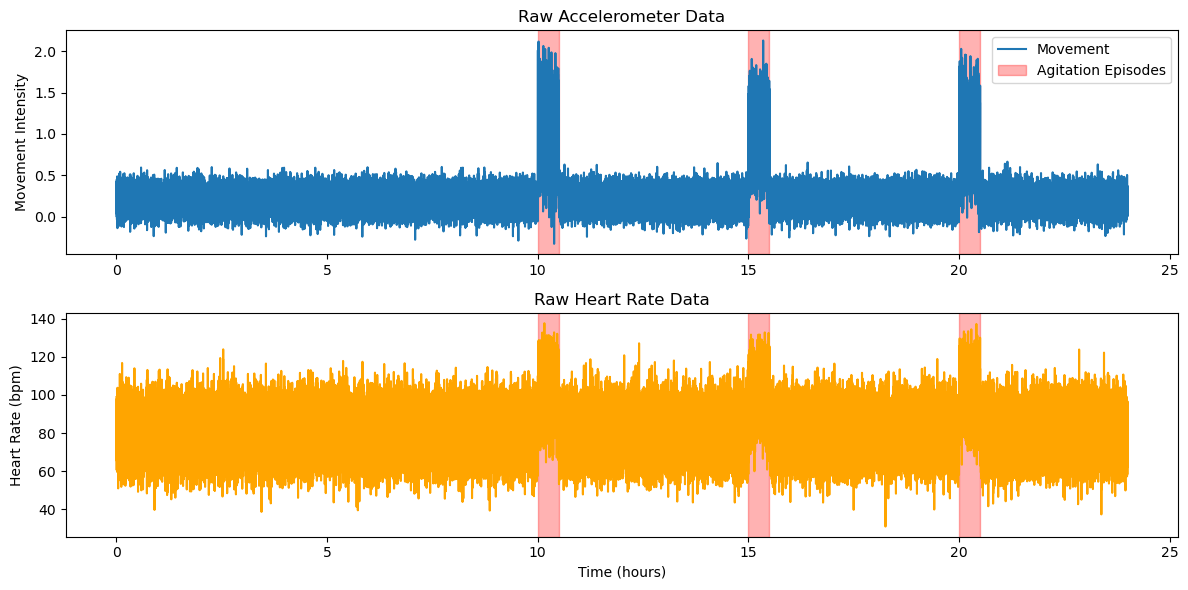

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['time']/3600, df['movement'], label='Movement')
plt.title('Raw Accelerometer Data')
plt.ylabel('Movement Intensity')
plt.axvspan(10, 10.5, color='red', alpha=0.3, label='Agitation Episodes')
plt.axvspan(15, 15.5, color='red', alpha=0.3)
plt.axvspan(20, 20.5, color='red', alpha=0.3)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['time']/3600, df['heart_rate'], label='Heart Rate', color='orange')
plt.title('Raw Heart Rate Data')
plt.xlabel('Time (hours)')
plt.ylabel('Heart Rate (bpm)')
plt.axvspan(10, 10.5, color='red', alpha=0.3)
plt.axvspan(15, 15.5, color='red', alpha=0.3)
plt.axvspan(20, 20.5, color='red', alpha=0.3)
plt.tight_layout()
plt.show()

Red-shaded regions: Simulated agitation episodes (10 AM, 3 PM, 8 PM).

Movement: Spikes during agitation.

Heart Rate: Increases during agitation.

Noise: Random fluctuations in both signals.

### Signal Processing
### Step 1: Filtering (Remove Noise)

Use a low-pass Butterworth filter to remove high-frequency noise from the movement and heart rate signals.

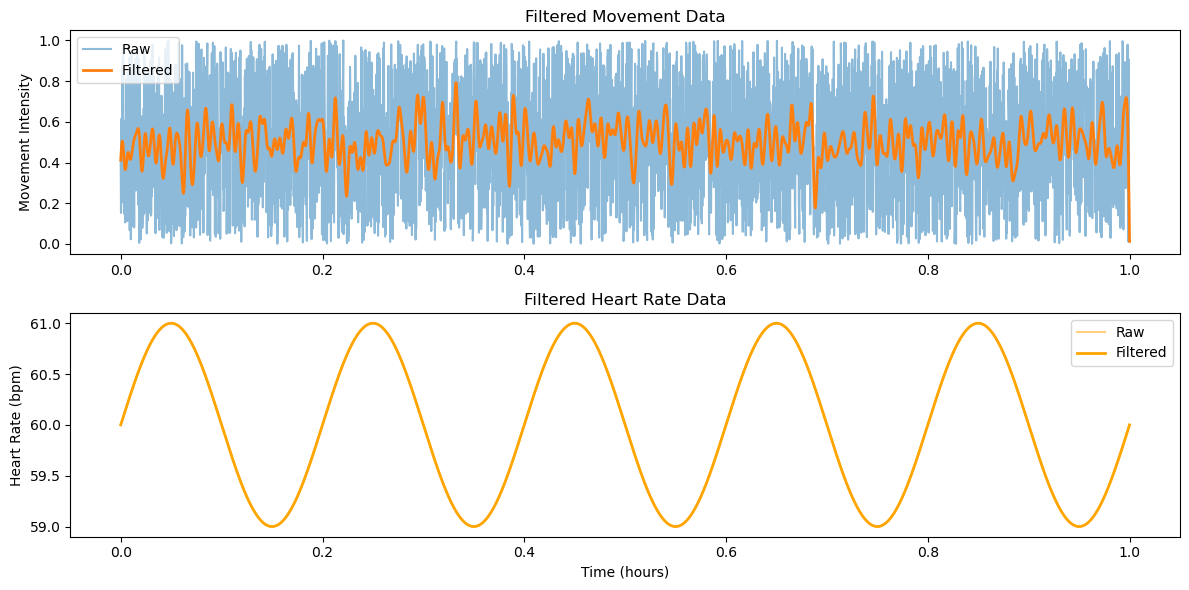

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    if cutoff <= 0 or cutoff >= nyquist:
        raise ValueError("Cutoff frequency must be between 0 and Nyquist frequency.")
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Example filter parameters
fs = 2.0  # Ensure this is set correctly
movement_cutoff = 0.1  # Hz (capture slow movements)
hr_cutoff = 0.5  # Hz (capture HR variability)

# Simulated DataFrame for demonstration
time = np.arange(0, 3600, 1)  # 1-hour of data in seconds
movement = np.random.rand(len(time))  # Simulated movement data
heart_rate = 60 + np.sin(np.linspace(0, 10*np.pi, len(time)))  # Simulated heart rate data

df = pd.DataFrame({'time': time, 'movement': movement, 'heart_rate': heart_rate})

# Apply filters
df['filtered_movement'] = apply_filter(df['movement'], movement_cutoff, fs)
df['filtered_hr'] = apply_filter(df['heart_rate'], hr_cutoff, fs)

# Plot filtered data
plt.figure(figsize=(12, 6))

# Movement data
plt.subplot(2, 1, 1)
plt.plot(df['time']/3600, df['movement'], label='Raw', alpha=0.5)
plt.plot(df['time']/3600, df['filtered_movement'], label='Filtered', linewidth=2)
plt.title('Filtered Movement Data')
plt.ylabel('Movement Intensity')
plt.legend()

# Heart rate data
plt.subplot(2, 1, 2)
plt.plot(df['time']/3600, df['heart_rate'], label='Raw', alpha=0.5, color='orange')
plt.plot(df['time']/3600, df['filtered_hr'], label='Filtered', linewidth=2, color='orange')
plt.title('Filtered Heart Rate Data')
plt.xlabel('Time (hours)')
plt.ylabel('Heart Rate (bpm)')
plt.legend()

plt.tight_layout()
plt.show()

Filtered movement: Smoothed to remove high-frequency noise while retaining agitation spikes.

Filtered HR: Smoothed to capture trends (e.g., sustained increases during agitation).

### Feature Extraction

Extract features from the filtered signals to quantify agitation.

Features for Movement:
Rolling Variance: Measures movement variability over time.

Peak Detection: Identify spikes in movement intensity.

Features for Heart Rate:
Mean HR: Average heart rate in a window.

HR Variability (HRV): Standard deviation of HR.

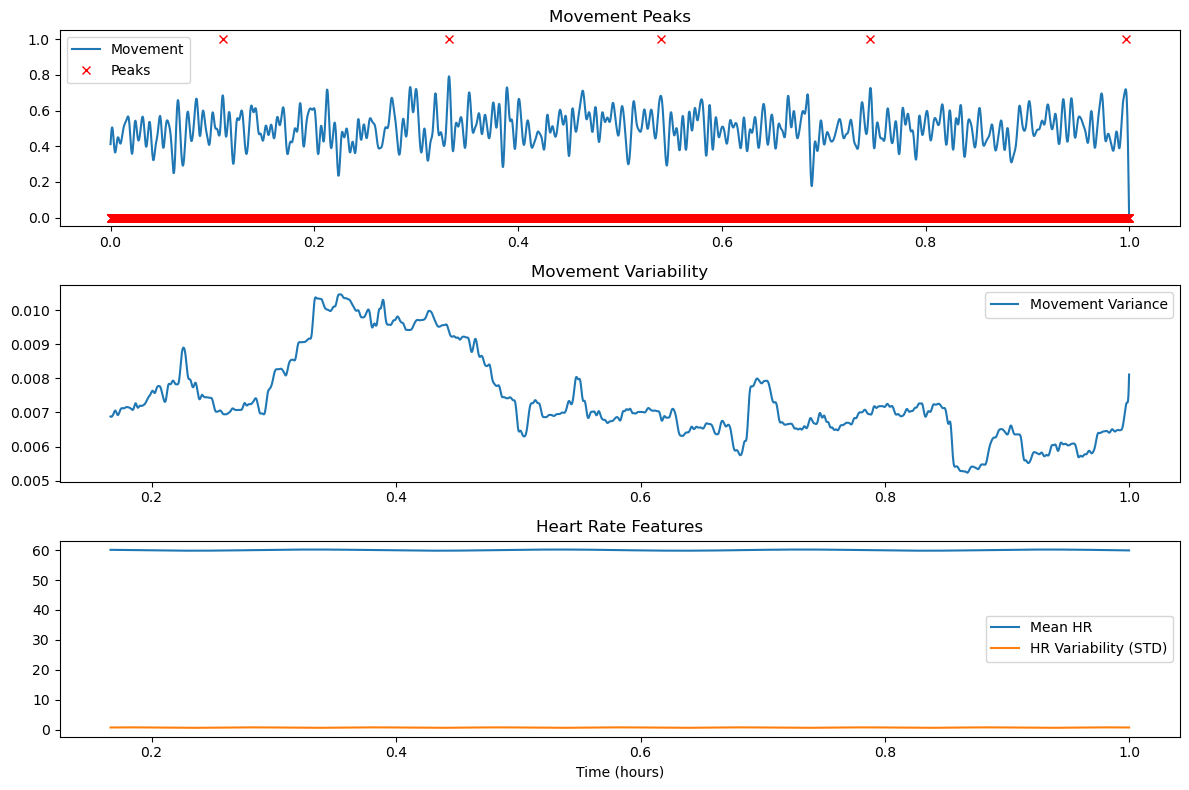

In [21]:
# Ensure fs is defined
fs = 2.0  # Example sampling frequency

# Calculate rolling variance (window = 5 minutes)
window_size = int(5 * 60 * fs)  # Convert to integer
df['movement_var'] = df['filtered_movement'].rolling(window=window_size).var()

# Detect peaks in movement (agitation)
from scipy.signal import find_peaks

peaks, _ = find_peaks(df['filtered_movement'], height=0.5, distance=window_size)
df['movement_peaks'] = 0
df.loc[peaks, 'movement_peaks'] = 1

# Calculate HR features
df['hr_mean'] = df['filtered_hr'].rolling(window=window_size).mean()
df['hr_std'] = df['filtered_hr'].rolling(window=window_size).std()

# Plot features
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(df['time']/3600, df['filtered_movement'], label='Movement')
plt.plot(df['time']/3600, df['movement_peaks'], 'rx', label='Peaks')
plt.title('Movement Peaks')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['time']/3600, df['movement_var'], label='Movement Variance')
plt.title('Movement Variability')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['time']/3600, df['hr_mean'], label='Mean HR')
plt.plot(df['time']/3600, df['hr_std'], label='HR Variability (STD)')
plt.title('Heart Rate Features')
plt.xlabel('Time (hours)')
plt.legend()
plt.tight_layout()
plt.show()

Movement peaks: Detected during agitation episodes.

HR variability: Increases during agitation.

In [29]:
df['agitation_label'] = 0
for t in agitation_times:
    start = t
    end = t + 30*60  # Adjust the duration if necessary
    indices = np.where((df['time'] >= start) & (df['time'] <= end))[0]
    df.loc[indices, 'agitation_label'] = 1

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Prepare data
X = df[['movement_var', 'hr_mean', 'hr_std']].fillna(0)
y = df['agitation_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
Confusion Matrix:
[[1080]]


agitation_label
0    3600
Name: count, dtype: int64


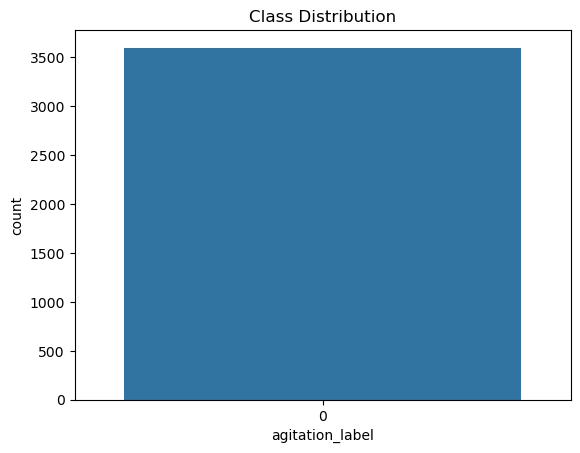

In [27]:
# Check class distribution
print(y.value_counts())

# Visualize the class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='agitation_label', data=df)
plt.title('Class Distribution')
plt.show()